### 02 - Add spatial pure definition and study the bboxes overlapping

In this notebook we add new columns to the already available spatial ones. Also, we plot all normalized bboxes regarding exp_004 and related to "spatial pure" rec clf.

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torchvision.ops import box_iou

from rec.utils import draw_bounding_boxes

pd.set_option('display.max_colwidth', None)

/home/nhormann/miniconda3/envs/rec-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BASE_PATH = "../code/rec/"

In [4]:
def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst


def add_pure_spatial(df_valid_results):
    mask_spatial_pure = (
        (df_valid_results.spatial == 1) &
        (df_valid_results.relational == 0) &
        (df_valid_results.ordinal == 0)
    )
    mask_right = df_valid_results.expr.str.contains("right")
    mask_left = df_valid_results.expr.str.contains("left")
    df_valid_results.loc[(mask_spatial_pure & mask_right), "spatial_pure_r"] = True
    df_valid_results.loc[~(mask_spatial_pure & mask_right), "spatial_pure_r"] = False
    df_valid_results.loc[(mask_spatial_pure & mask_left), "spatial_pure_l"] = True
    df_valid_results.loc[~(mask_spatial_pure & mask_left), "spatial_pure_l"] = False
    return df_valid_results


def normalize_bbox(bbox, width, height, scalar=500):
     return [
         int(scalar * (bbox[0] / width)),
         int(scalar * (bbox[1] / height)),
         int(scalar * (bbox[2] / width)),
         int(scalar * (bbox[3] / height)),
     ]


def add_normalized_bboxes(df_valid_results, bbox_column_name):
    bboxes_norm = []
    for _, row in df_valid_results.loc[:, ["img_filename", bbox_column_name]].iterrows():
        im = Image.open(f"{BASE_PATH}{row['img_filename']}")
        w, h = im.size
        bboxes_norm.append(normalize_bbox(row[bbox_column_name], w, h))
    df_valid_results.loc[:, f"{bbox_column_name}_norm"] = bboxes_norm
    return df_valid_results

### Read validation data

In [5]:
df_valid_results = pd.read_parquet("../models/exp_004/predictions_val.parquet")

In [6]:
df_valid_results.head()

,bbox_raw,bbox_pred,img_filename,expr,hits,spatial,ordinal,relational,intrinsic
0,"[156.0, 169.0, 224.0, 360.0]","[49.481747, 99.540726, 301.4215, 272.09885]",refer/data/images/saiapr_tc-12/10/images/10890.jpg,person on the left,0.0,1,0,0,0
1,"[0.0, 94.0, 480.0, 360.0]","[62.72489, 94.11238, 340.92255, 246.16074]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,the trees,0.0,0,0,0,1
2,"[110.0, 64.0, 296.0, 183.0]","[65.14025, 65.82784, 359.55045, 232.00388]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,sky next to clouds,0.0,1,0,1,0
3,"[201.0, 49.0, 331.0, 184.0]","[60.592358, 81.93651, 333.8043, 234.55069]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,clouds,0.0,0,0,0,1
4,"[176.0, 56.0, 478.0, 195.0]","[64.9345, 103.80368, 327.54202, 251.31976]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,mountain,0.0,0,0,0,1


In [7]:
df_valid_results.shape

(6333, 9)

In [8]:
df_valid_results_exp003 = pd.read_parquet("../models/exp_003/predictions_val.parquet")

In [9]:
df_valid_results_exp003.head()

,bbox_raw,bbox_pred,img_filename,expr,hits,spatial,ordinal,relational,intrinsic
0,"[156.0, 169.0, 224.0, 360.0]","[150.1989, 168.85612, 214.18504, 359.0]",refer/data/images/saiapr_tc-12/10/images/10890.jpg,person on the left,1.0,1,0,0,0
1,"[0.0, 94.0, 480.0, 360.0]","[6.03527, 42.10663, 479.0, 359.0]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,the trees,1.0,0,0,0,1
2,"[110.0, 64.0, 296.0, 183.0]","[84.89125, 41.48004, 285.32928, 176.66406]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,sky next to clouds,1.0,1,0,1,0
3,"[201.0, 49.0, 331.0, 184.0]","[183.9086, 85.440216, 307.06946, 178.0696]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,clouds,1.0,0,0,0,1
4,"[176.0, 56.0, 478.0, 195.0]","[0.74645513, 0.0, 479.0, 359.0]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,mountain,0.0,0,0,0,1


Merge both exp_004 results and exp_003 predictions.

In [10]:
df_valid_results = df_valid_results.join(df_valid_results_exp003.loc[:, ["bbox_pred"]], rsuffix='_exp003')

In [11]:
df_valid_results.head()

,bbox_raw,bbox_pred,img_filename,expr,hits,spatial,ordinal,relational,intrinsic,bbox_pred_exp003
0,"[156.0, 169.0, 224.0, 360.0]","[49.481747, 99.540726, 301.4215, 272.09885]",refer/data/images/saiapr_tc-12/10/images/10890.jpg,person on the left,0.0,1,0,0,0,"[150.1989, 168.85612, 214.18504, 359.0]"
1,"[0.0, 94.0, 480.0, 360.0]","[62.72489, 94.11238, 340.92255, 246.16074]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,the trees,0.0,0,0,0,1,"[6.03527, 42.10663, 479.0, 359.0]"
2,"[110.0, 64.0, 296.0, 183.0]","[65.14025, 65.82784, 359.55045, 232.00388]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,sky next to clouds,0.0,1,0,1,0,"[84.89125, 41.48004, 285.32928, 176.66406]"
3,"[201.0, 49.0, 331.0, 184.0]","[60.592358, 81.93651, 333.8043, 234.55069]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,clouds,0.0,0,0,0,1,"[183.9086, 85.440216, 307.06946, 178.0696]"
4,"[176.0, 56.0, 478.0, 195.0]","[64.9345, 103.80368, 327.54202, 251.31976]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,mountain,0.0,0,0,0,1,"[0.74645513, 0.0, 479.0, 359.0]"


Add pure spatial definition columns:

In [12]:
df_valid_results = add_pure_spatial(df_valid_results)

In [13]:
df_valid_results.query("(spatial_pure_r == True) and spatial_pure_l == True").loc[:, ["expr", "spatial_pure_r", "spatial_pure_l"]]

,expr,spatial_pure_r,spatial_pure_l
980,part of bright white table middle left,True,True
1412,"top left corner there are two lights , not the ones to the right in the corner",True,True
4386,i said left ! bottom right corner,True,True
4753,bright cliff in top left,True,True
5490,row of 4 paintings on left ( to the left of the 4 on right,True,True
5667,sky right above building on left,True,True
6287,the bottom right corner to the left of light pole,True,True


In [14]:
ambiguous_idx = df_valid_results.query("(spatial_pure_r == True) and spatial_pure_l == True").index

In [15]:
df_valid_results = df_valid_results.drop(ambiguous_idx).reset_index(drop=True)

In [16]:
df_valid_results.spatial_pure_l.value_counts()

False    5437
True      889
Name: spatial_pure_l, dtype: int64

In [17]:
df_valid_results.spatial_pure_r.value_counts()

False    5494
True      832
Name: spatial_pure_r, dtype: int64

In [18]:
df_valid_results.query("spatial_pure_r == 1").hits.value_counts()

0.0    811
1.0     21
Name: hits, dtype: int64

In [19]:
df_valid_results.query("spatial_pure_l == 1").hits.value_counts()

0.0    876
1.0     13
Name: hits, dtype: int64

Add normalized bboxes values:

In [20]:
df_valid_results = add_normalized_bboxes(df_valid_results, "bbox_pred")
df_valid_results = add_normalized_bboxes(df_valid_results, "bbox_pred_exp003")

In [21]:
df_valid_results.head()

,bbox_raw,bbox_pred,img_filename,expr,hits,spatial,ordinal,relational,intrinsic,bbox_pred_exp003,spatial_pure_r,spatial_pure_l,bbox_pred_norm,bbox_pred_exp003_norm
0,"[156.0, 169.0, 224.0, 360.0]","[49.481747, 99.540726, 301.4215, 272.09885]",refer/data/images/saiapr_tc-12/10/images/10890.jpg,person on the left,0.0,1,0,0,0,"[150.1989, 168.85612, 214.18504, 359.0]",False,True,"[51, 138, 313, 377]","[156, 234, 223, 498]"
1,"[0.0, 94.0, 480.0, 360.0]","[62.72489, 94.11238, 340.92255, 246.16074]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,the trees,0.0,0,0,0,1,"[6.03527, 42.10663, 479.0, 359.0]",False,False,"[65, 130, 355, 341]","[6, 58, 498, 498]"
2,"[110.0, 64.0, 296.0, 183.0]","[65.14025, 65.82784, 359.55045, 232.00388]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,sky next to clouds,0.0,1,0,1,0,"[84.89125, 41.48004, 285.32928, 176.66406]",False,False,"[67, 91, 374, 322]","[88, 57, 297, 245]"
3,"[201.0, 49.0, 331.0, 184.0]","[60.592358, 81.93651, 333.8043, 234.55069]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,clouds,0.0,0,0,0,1,"[183.9086, 85.440216, 307.06946, 178.0696]",False,False,"[63, 113, 347, 325]","[191, 118, 319, 247]"
4,"[176.0, 56.0, 478.0, 195.0]","[64.9345, 103.80368, 327.54202, 251.31976]",refer/data/images/saiapr_tc-12/03/images/3593.jpg,mountain,0.0,0,0,0,1,"[0.74645513, 0.0, 479.0, 359.0]",False,False,"[67, 144, 341, 349]","[0, 0, 498, 498]"


In [22]:
df_spatial_l = df_valid_results.query("spatial_pure_l == 1")
df_spatial_r = df_valid_results.query("spatial_pure_r == 1")

#### Left study

In [37]:
T = 0.5
bbox_left_x1s = [250, 240, 230, 220, 210, 200, 190, 180, 170, 160, 150, 125, 100, 75, 50]

In [38]:
len(bbox_left_x1s)

15

In [39]:
hits_ratios = []
for bb_l_x1 in bbox_left_x1s:
    hits_l = []
    for _, row in df_spatial_l.loc[:, ["bbox_pred_norm"]].iterrows():
        bb_tensor = torch.Tensor(row["bbox_pred_norm"])
        bbox_l = torch.Tensor([0.0, row["bbox_pred_norm"][1], bb_l_x1, row["bbox_pred_norm"][3]])
        iou_ = box_iou(bb_tensor.reshape(-1, 4), bbox_l.reshape(-1, 4))
        hits_l.append((iou_ > T).item())
    hits_ratios.append((sum(hits_l) / len(hits_l)))

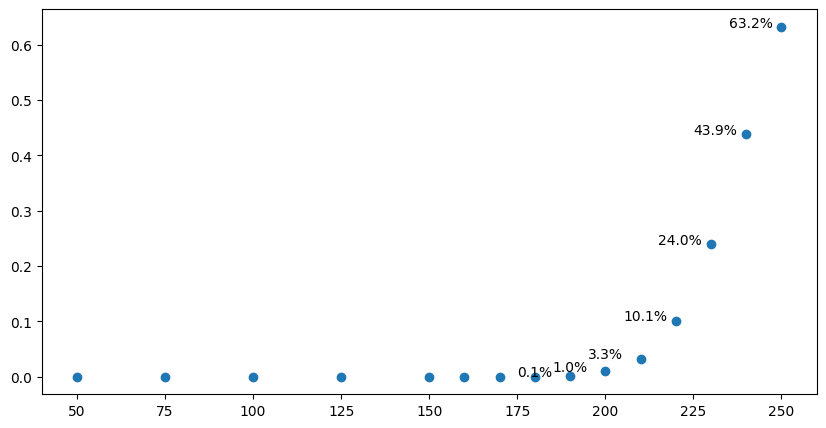

In [40]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(bbox_left_x1s, hits_ratios)
for i, txt in enumerate(hits_ratios):
    if txt > 0:
        ax.annotate(f"{txt*100:.1f}%", (bbox_left_x1s[i] - 15, hits_ratios[i]))

#### Right study

In [41]:
T = 0.5
bbox_r_x0s = [250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 375, 400, 425, 450]

In [42]:
hits_ratios_r = []
for bb_r_x0 in bbox_r_x0s:
    hits_r = []
    for _, row in df_spatial_r.loc[:, ["bbox_pred_norm"]].iterrows():
        bb_tensor = torch.Tensor(row["bbox_pred_norm"])
        bbox_r = torch.Tensor([bb_r_x0, row["bbox_pred_norm"][1], 500.0, row["bbox_pred_norm"][3]])
        iou_ = box_iou(bb_tensor.reshape(-1, 4), bbox_r.reshape(-1, 4))
        hits_r.append((iou_ > T).item())
    hits_ratios_r.append((sum(hits_r) / len(hits_r)))

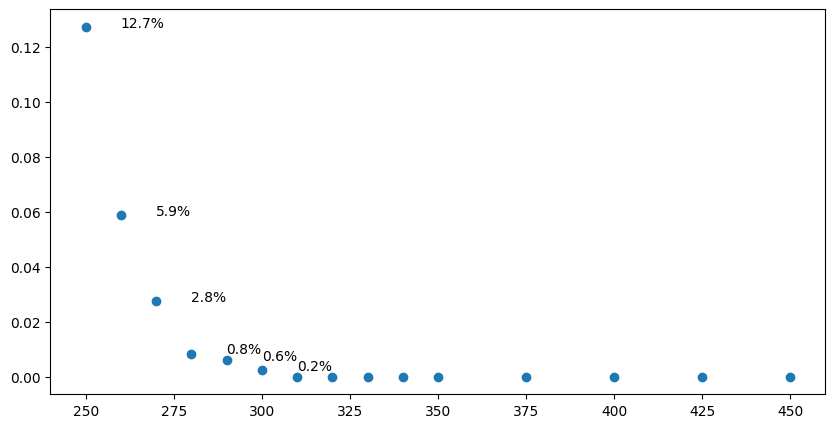

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(bbox_r_x0s, hits_ratios_r)
for i, txt in enumerate(hits_ratios_r):
    if txt > 0:
        ax.annotate(f"{txt*100:.1f}%", (bbox_r_x0s[i] + 10, hits_ratios_r[i]))